In [39]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statistics import mean
from datetime import date
import file

In [40]:
# Define the ticker symbol
tickerSymbol = 'USD'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
history = tickerData.history(interval='1wk', start='2023-1-1', end=date.today())
# display(history)

In [41]:

gap = 0

option_prices = {
    1: [94/1.95],
    2: [90/4.05, 92/7.30],
    3: [91/5.15],
    4: [81/5.4, 74/5.1, 131/12.1, 65/6.1],
    5: [100/7.05, 126/12.05, 65/6.25],
    6: [94/7.4, 92/11.30],
    7: [90/8.25],
    8: [91/8.05, 131/16.05],
    9: [81/8.45, 100/9.4, 126/15.6, 65/8.25, 65/8.55],
    10: [93/13.95],
    12: [131/19.6],
    13: [100/11.5, 126/19.2],
    14: [94/10.55, 65/10.05],
    15: [90/11.15],
    16: [91/12.75],
    17: [81/11.3, 74/10.4],
    21: [65/12.2],
    24: [93/19.50],
    26: [100/18.55, 131/27.85, 65/13.65],
    27: [94/17.25, 126/26.35],
    28: [90/16.9],
    29: [91/17.55],
    30: [81/14.95],
    34: [65/16.1]
}

print('raw option leverages:')
for w in sorted(option_prices.keys()):
    print(f'\t{w:2}w', *[f'{x:4.1f}' for x in option_prices[w]])

option_leverage = {w:mean(option_prices[w]) for w in option_prices}

# normalize values so longer expirations have lower leverage
option_leverage = {k: v for k, v in zip(sorted(option_leverage.keys()), sorted(option_leverage.values(), reverse=True))}

print('sorted mean option leverage, break even:')
for w, v in sorted(option_leverage.items()):
    print(f'\t{w:2}w {v:4.1f} {gap + 100/v:4.1f}%')
print(f'option gap: {gap:.2f}%')

file.save_option_leverage(tickerSymbol, option_leverage)

raw option leverages:
	 1w 48.2
	 2w 22.2 12.6
	 3w 17.7
	 4w 15.0 14.5 10.8 10.7
	 5w 14.2 10.5 10.4
	 6w 12.7  8.1
	 7w 10.9
	 8w 11.3  8.2
	 9w  9.6 10.6  8.1  7.9  7.6
	10w  6.7
	12w  6.7
	13w  8.7  6.6
	14w  8.9  6.5
	15w  8.1
	16w  7.1
	17w  7.2  7.1
	21w  5.3
	24w  4.8
	26w  5.4  4.7  4.8
	27w  5.4  4.8
	28w  5.3
	29w  5.2
	30w  5.4
	34w  4.0
sorted mean option leverage, break even:
	 1w 48.2  2.1%
	 2w 17.7  5.7%
	 3w 17.4  5.7%
	 4w 12.7  7.8%
	 5w 11.7  8.6%
	 6w 10.9  9.2%
	 7w 10.4  9.6%
	 8w  9.7 10.3%
	 9w  8.8 11.4%
	10w  8.1 12.4%
	12w  7.7 13.0%
	13w  7.6 13.1%
	14w  7.1 14.0%
	15w  7.1 14.0%
	16w  6.7 15.0%
	17w  6.7 15.0%
	21w  5.4 18.5%
	24w  5.3 18.8%
	26w  5.3 18.8%
	27w  5.2 19.3%
	28w  5.1 19.5%
	29w  5.0 20.2%
	30w  4.8 21.0%
	34w  4.0 24.8%
option gap: 0.00%


In [42]:
max_weeks = 52
stock_change = [None]
option_performance = []
for weeks in range(1, max_weeks+1):
    stock_changes = history['Close'].pct_change(periods=weeks) * 100
    stock_change.append(stock_changes.median())
    window_max = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()

    if weeks in option_leverage:
        lvr = option_leverage[weeks]
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() #* 52 / weeks # annualized
        median_profit = option_profits.median()
        positive_percent = (option_profits > 0).mean() * 100
        wmax = (((window_max / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100).median() - 100
        option_performance.append([weeks, mean_profit, positive_percent, wmax, median_profit])
        history[f'Option {weeks}w'] = option_profits # * 52 / weeks # annualized

In [43]:
print('Option performance (weeks, profit, positive, w max):')
for p in option_performance:
    weeks = p[0]
    print(f'\t{weeks:2}w {p[1]:4.0f}% {p[2]:3.0f}% {p[3]:4.0f}%')

Option performance (weeks, profit, positive, w max):
	 1w  142%  45%  104%
	 2w   39%  45%   -9%
	 3w   84%  49%   82%
	 4w   58%  50%   24%
	 5w   74%  51%   36%
	 6w   91%  55%   48%
	 7w  108%  56%   80%
	 8w  121%  61%   93%
	 9w  118%  58%  115%
	10w  121%  59%  144%
	12w  148%  65%  226%
	13w  166%  66%  266%
	14w  167%  67%  258%
	15w  184%  71%  297%
	16w  184%  72%  300%
	17w  202%  69%  325%
	21w  217%  74%  289%
	24w  259%  79%  362%
	26w  296%  87%  416%
	27w  305%  85%  445%
	28w  316%  90%  485%
	29w  321%  91%  480%
	30w  323%  93%  458%
	34w  329% 100%  400%


In [44]:
from file import save_file

save_file(tickerSymbol, option_performance)

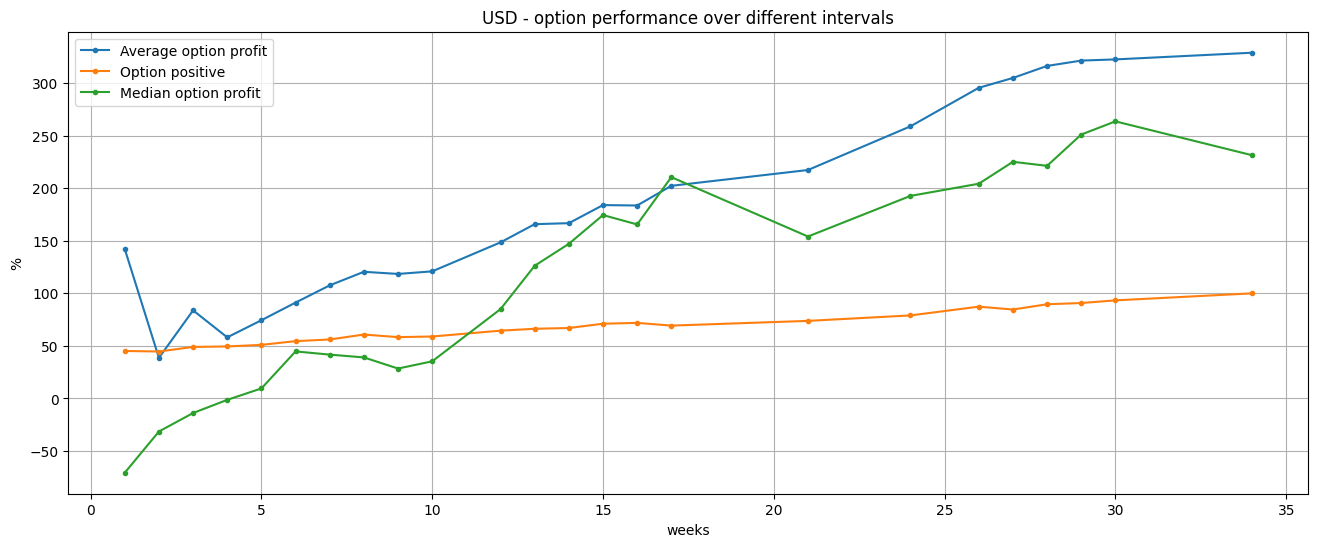

In [45]:
plt.figure(figsize=(16,6))
option_weeks = [p[0] for p in option_performance]
option_profit = [p[1] for p in option_performance]
option_positive = [p[2] for p in option_performance]
option_mprofit = [p[4] for p in option_performance]
option_score = [x * y / 100 for x, y in zip(option_profit, option_positive)]
plt.plot(option_weeks, option_profit, label='Average option profit', marker='.')
plt.plot(option_weeks, option_positive, label='Option positive', marker='.')
# plt.plot(option_weeks, option_score, label='Option score', marker='.')
plt.plot(option_weeks, option_mprofit, label='Median option profit', marker='.')
plt.legend()
plt.title(f'{tickerSymbol} - option performance over different intervals')
plt.xlabel('weeks')
plt.ylabel('%')
plt.grid()
plt.show()

In [46]:
# weeks = 3
# maxprofit = 200
# lvr = option_leverage[weeks]
# history['WClose'] = history.Close.shift(weeks)
# history['WHigh'] = history.High.rolling(window=weeks).max()
# history['w_profit'] = (((history.Close / history.WClose - 1) * 100 - gap) * lvr - 100).clip(lower=-100)
# history['wmax_profit'] = (((history.WHigh / history.WClose - 1) * 100 - gap) * lvr - 100)
# wmax_profit = history.wmax_profit.clip(upper=maxprofit)
# history['profit'] = wmax_profit.where(wmax_profit >= maxprofit, history.w_profit)
# display(history[weeks:])

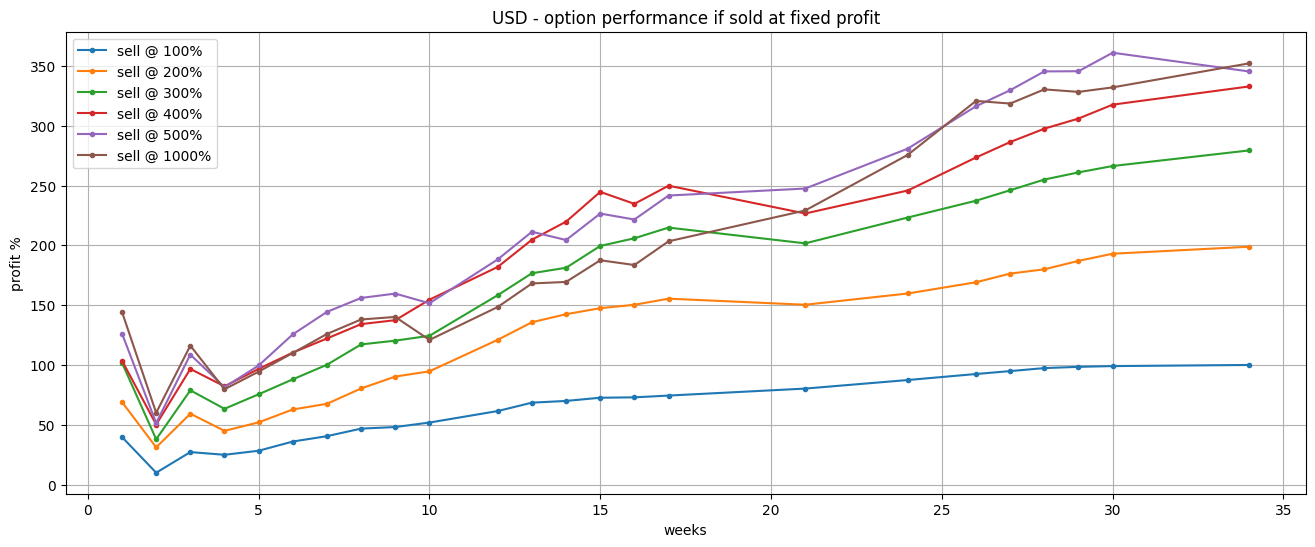

In [47]:
plt.figure(figsize=(16,6))

for maxprofit in [100,200,300,400,500,1000]:
    data = {}
    for weeks in option_leverage:
        lvr = option_leverage[weeks]
        WStart = history.Close.shift(weeks)
        WHigh = history.High.rolling(window=weeks).max()
        eow_profit = (((history.Close / WStart - 1) * 100 - gap) * lvr - 100).clip(lower=-100)
        wmax_profit = (((WHigh / WStart - 1) * 100 - gap) * lvr - 100).clip(upper=maxprofit)
        profit = wmax_profit.where(wmax_profit >= maxprofit, eow_profit)
        data[weeks] = profit[weeks:].mean()

    plt.plot(*zip(*sorted(data.items())), label=f'sell @ {maxprofit}%', marker='.')

plt.legend(loc='best')
plt.title(f'{tickerSymbol} - option performance if sold at fixed profit')
plt.xlabel('weeks')
plt.ylabel('profit %')
plt.grid()
plt.show()

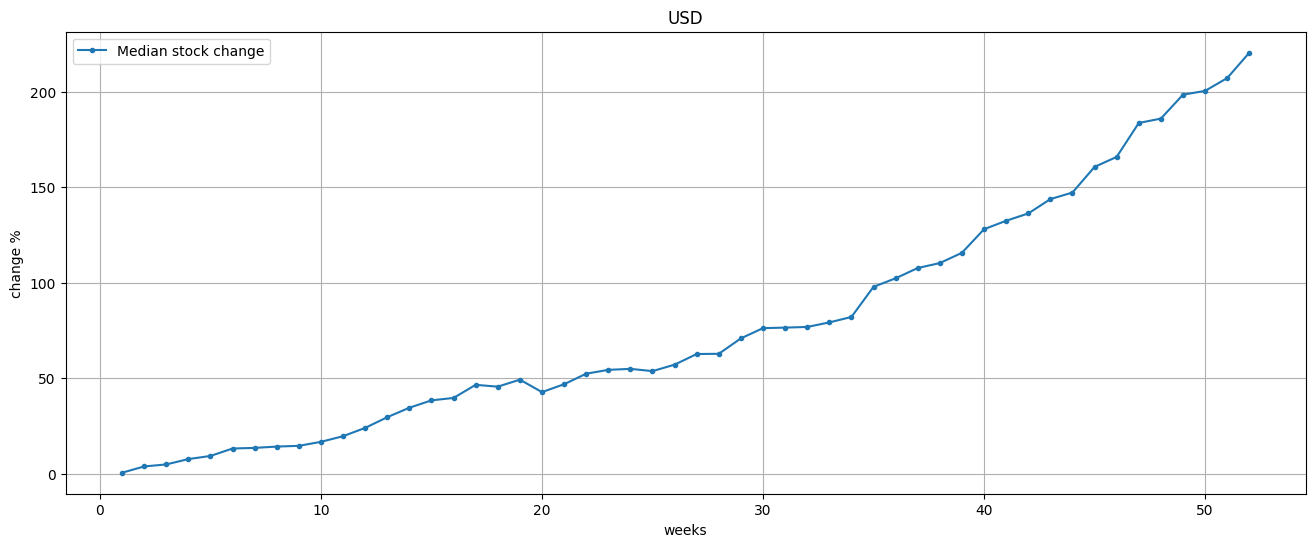

In [48]:
plt.figure(figsize=(16,6))
plt.plot(stock_change, label='Median stock change', marker='.')
plt.legend(loc='best')
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('change %')
plt.grid()
plt.show()


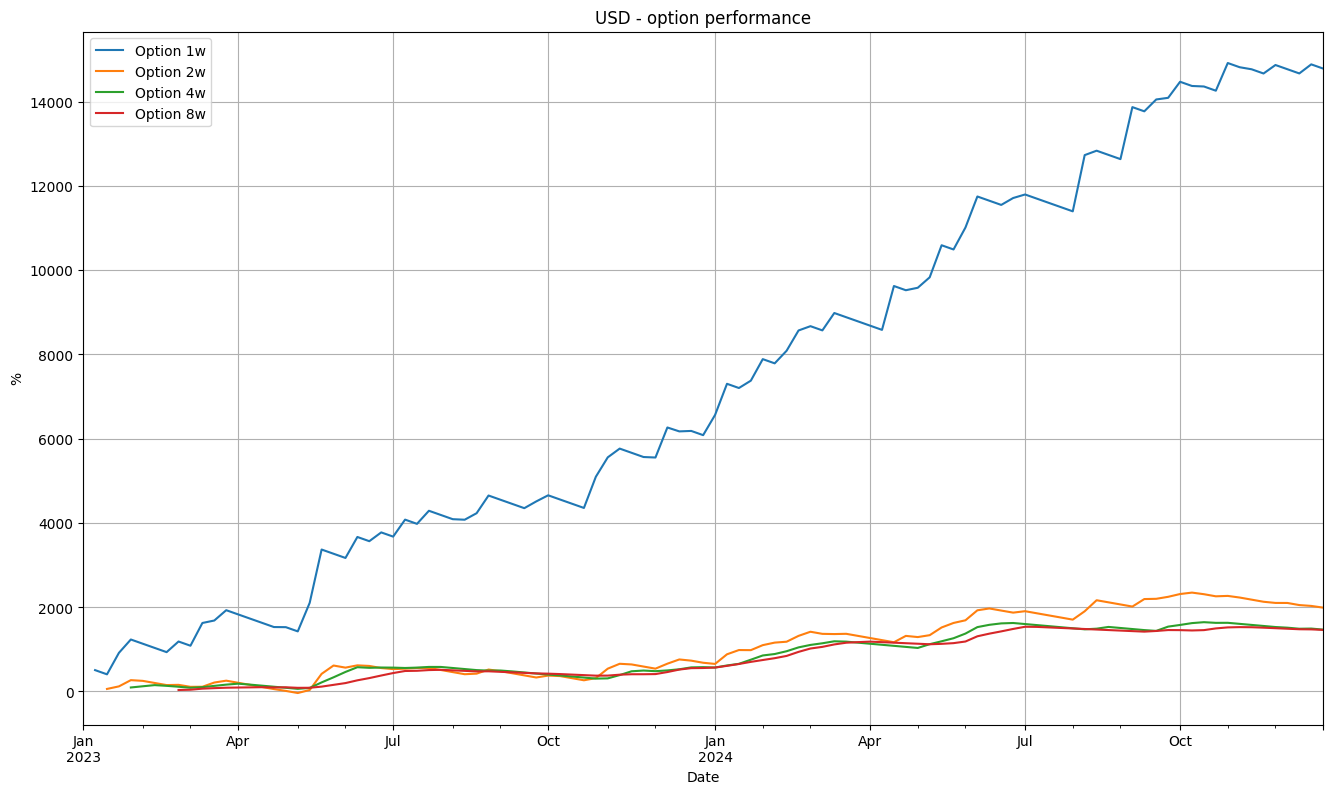

In [49]:
plt.figure(figsize=(16,9))

for w in [1,2,4,8]:
    (history[f'Option {w}w'].cumsum()/w).plot()

plt.legend(loc='upper left')
plt.title(f'{tickerSymbol} - option performance')
plt.ylabel('%')
plt.grid()
plt.show()


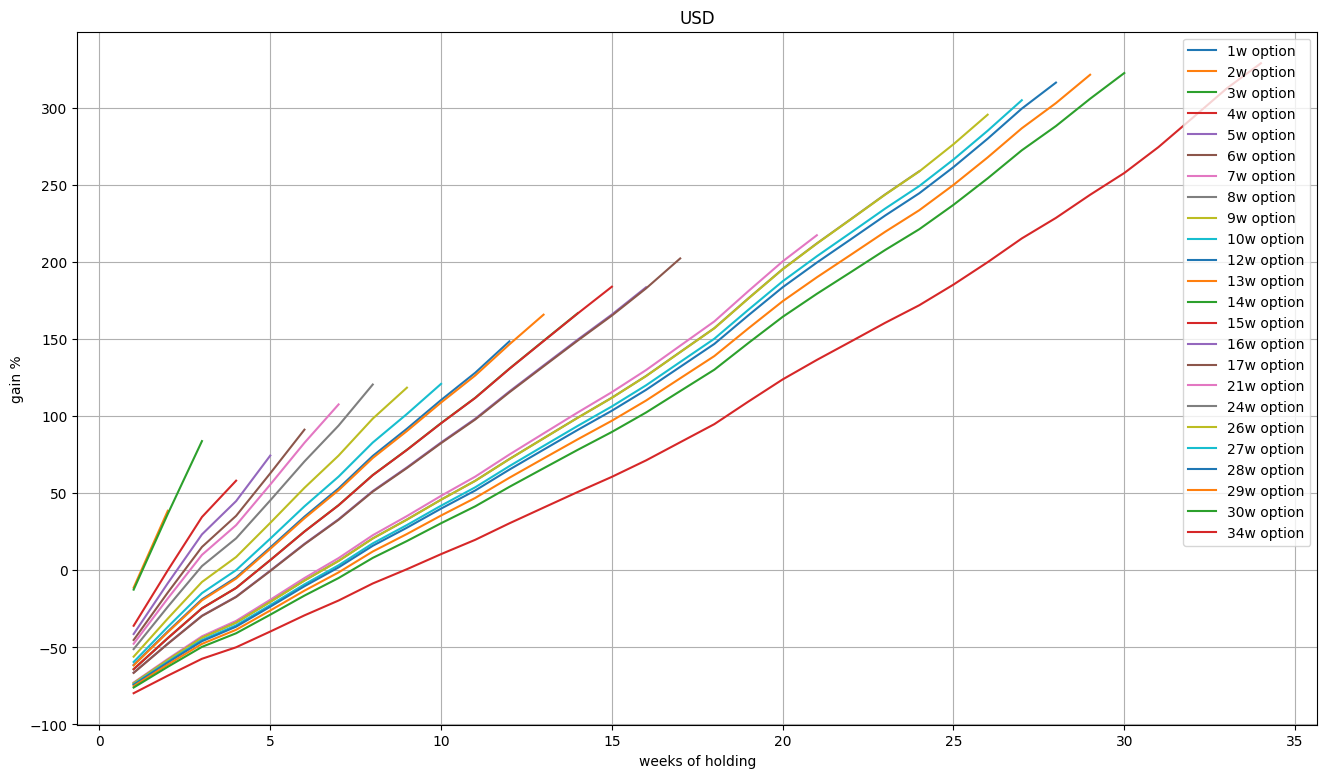

In [50]:
plt.figure(figsize=(16,9))

for w in option_leverage:
    lvr = option_leverage[w]
    gains = [None]
    for weeks in range(1, w+1):
        stock_changes = history['Close'].pct_change(periods=weeks) * 100
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() #* 52 / weeks # annualized
        gains.append(mean_profit if mean_profit > -100 else None)
    plt.plot(gains, label=f'{w}w option')
        
plt.legend(loc='upper right')
plt.title(tickerSymbol)
plt.xlabel('weeks of holding')
plt.ylabel('gain %')
plt.grid()
plt.show()